<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RL_TD_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class TDActorCritic(nn.Module):
    def __init__(self,
             policy_net,
             value_net,
             gamma: float = 1.0,
             lr: float = 0.0002):
        super(TDActorCritic, self).__init__()
        self.policy_net = policy_net # (1) Poliy network ( parameter : theta )
        self.value_net = value_net # (2) Value Network ( parameter : psi )
        self.gamma = gamma
        self.lr = lr

        # two parameters : (1) theta &  (2) psi
        total_param = list(policy_net.parameters()) + list(value_net.parameters())
        self.optimizer = torch.optim.Adam(params=total_param, lr=lr)

        self._eps = 1e-25
        self._mse = torch.nn.MSELoss()

    def get_action(self, state):
        with torch.no_grad():
            logits = self.policy(state)
            action_dist = Categorical(logits=logits)
            action = action_dist.sample()
            return action

    def update(self, s, a, r, s_, d):
        # (1) TD target & error 계산하기
        with torch.no_grad():
            td_target = reward + self.gamma * self.value_net(s_) * (1-d)
            td_error = td_target - self.value_net(s)

        # (2) (Loss 계산 위해) log prob 계산하기
        dist = Categorical(logits=self.policy_net(s))
        prob = dist.probs.gather(1, a)

        # (3) 현재 state의 value 계산
        v = self.value_net(s)

        # (4) Loss 계산
        loss1 = -torch.log(prob + self._eps) * td_error
        loss2 = self._mse(v, td_target)
        loss = (loss1+loss2).mean()

        # (5) Gradient Descent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

(Online) Actor-Critic 방식으로 CartPole 예시를 학습하는 코드이다.

추가로, TD error를 사용하므로 TD Actor-Critic 알고리즘이다.

단일 agent(worker가 하나)가 순차적으로 학습하므로 A2C는 아님

In [10]:
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Actor-Critic 네트워크 정의
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()
        # 입력 상태를 은닉층으로 전달
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        # Actor head: 정책(logits)을 출력 (각 행동에 대한 점수)
        self.actor = nn.Linear(hidden_dim, action_dim)
        # Critic head: 상태의 가치(value)를 출력
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        # Actor와 Critic의 출력을 각각 계산
        policy_logits = self.actor(x)
        value = self.critic(x)
        return policy_logits, value

def train():
    # 하이퍼파라미터 설정
    learning_rate = 0.001
    gamma = 0.99
    max_episodes = 1000

    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]   # 상태 차원 (CartPole은 4차원)
    action_dim = env.action_space.n              # 행동의 개수 (CartPole은 2개)

    # Actor-Critic 모델과 Adam 옵티마이저 생성
    model = ActorCritic(state_dim, action_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 에피소드별 학습 루프 시작
    for episode in range(max_episodes):
        state = env.reset()
        state = torch.FloatTensor(state)
        done = False
        total_reward = 0

        # 에피소드가 끝날 때까지 반복
        while not done:
            # 현재 상태를 입력으로 받아 정책(logits)과 상태 가치 예측
            policy_logits, value = model(state)
            # 소프트맥스 함수를 이용해 각 행동의 확률 계산
            policy = F.softmax(policy_logits, dim=-1) # dim=-1: 마지막 차원을 기준으로 softmax를 적용
            # 확률 분포에서 행동 샘플링
            dist = torch.distributions.Categorical(policy)
            action = dist.sample()

            # 선택한 행동으로 환경에서 한 스텝 진행
            next_state, reward, done, _ = env.step(action.item())
            total_reward += reward

            next_state = torch.FloatTensor(next_state)
            reward_tensor = torch.tensor([reward], dtype=torch.float) # reward를 텐서로 변환 (차원 맞추기)

            # 다음 상태에 대한 가치 예측 (에피소드 종료 시 0으로 처리)
            with torch.no_grad():
                _, next_value = model(next_state)
            done_mask = 0.0 if done else 1.0

            td_target = reward_tensor + gamma * next_value * done_mask
            advantage = td_target - value
            # advantage 는 $\delta$ (즉 TD 에러) 다.

            # Actor loss: 로그 확률과 advantage를 곱해 계산 (policy gradient)
            actor_loss = -dist.log_prob(action) * advantage
            # Critic loss: advantage의 제곱 (MSE)
            critic_loss = advantage.pow(2)
            # 총 손실: Actor loss와 Critic loss의 합
            loss = actor_loss + critic_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        # 에피소드 종료 후 총 보상 출력
        print("에피소드: {}, 총 보상: {}".format(episode, total_reward))

if __name__ == '__main__':
    train()

에피소드: 0, 총 보상: 21.0
에피소드: 1, 총 보상: 15.0
에피소드: 2, 총 보상: 21.0
에피소드: 3, 총 보상: 38.0
에피소드: 4, 총 보상: 23.0
에피소드: 5, 총 보상: 30.0
에피소드: 6, 총 보상: 10.0
에피소드: 7, 총 보상: 40.0
에피소드: 8, 총 보상: 12.0
에피소드: 9, 총 보상: 14.0
에피소드: 10, 총 보상: 8.0
에피소드: 11, 총 보상: 11.0
에피소드: 12, 총 보상: 9.0
에피소드: 13, 총 보상: 9.0
에피소드: 14, 총 보상: 8.0
에피소드: 15, 총 보상: 10.0
에피소드: 16, 총 보상: 9.0
에피소드: 17, 총 보상: 9.0
에피소드: 18, 총 보상: 10.0
에피소드: 19, 총 보상: 10.0
에피소드: 20, 총 보상: 12.0
에피소드: 21, 총 보상: 12.0
에피소드: 22, 총 보상: 9.0
에피소드: 23, 총 보상: 11.0
에피소드: 24, 총 보상: 10.0
에피소드: 25, 총 보상: 10.0
에피소드: 26, 총 보상: 11.0
에피소드: 27, 총 보상: 9.0
에피소드: 28, 총 보상: 10.0
에피소드: 29, 총 보상: 10.0
에피소드: 30, 총 보상: 13.0
에피소드: 31, 총 보상: 9.0
에피소드: 32, 총 보상: 11.0
에피소드: 33, 총 보상: 10.0
에피소드: 34, 총 보상: 9.0
에피소드: 35, 총 보상: 9.0
에피소드: 36, 총 보상: 10.0
에피소드: 37, 총 보상: 11.0
에피소드: 38, 총 보상: 10.0
에피소드: 39, 총 보상: 9.0
에피소드: 40, 총 보상: 8.0
에피소드: 41, 총 보상: 8.0
에피소드: 42, 총 보상: 10.0
에피소드: 43, 총 보상: 10.0
에피소드: 44, 총 보상: 10.0
에피소드: 45, 총 보상: 10.0
에피소드: 46, 총 보상: 11.0
에피소드: 47, 총 보상: 8.0
에피소드: 48, 총 보상: 9

Episode 1: Reward = 65.0
Episode 2: Reward = 65.0
Episode 3: Reward = 30.0
Episode 4: Reward = 58.0
Episode 5: Reward = 32.0
Episode 6: Reward = 83.0
Episode 7: Reward = 11.0
Episode 8: Reward = 11.0
Episode 9: Reward = 16.0
Episode 10: Reward = 49.0
Episode 11: Reward = 58.0
Episode 12: Reward = 141.0
Episode 13: Reward = 62.0
Episode 14: Reward = 23.0
Episode 15: Reward = 29.0
Episode 16: Reward = 53.0
Episode 17: Reward = 34.0
Episode 18: Reward = 18.0
Episode 19: Reward = 14.0
Episode 20: Reward = 12.0
Episode 21: Reward = 10.0
Episode 22: Reward = 12.0
Episode 23: Reward = 14.0
Episode 24: Reward = 20.0
Episode 25: Reward = 26.0
Episode 26: Reward = 26.0
Episode 27: Reward = 31.0
Episode 28: Reward = 73.0
Episode 29: Reward = 25.0
Episode 30: Reward = 27.0
Episode 31: Reward = 32.0
Episode 32: Reward = 41.0
Episode 33: Reward = 33.0
Episode 34: Reward = 21.0
Episode 35: Reward = 21.0
Episode 36: Reward = 18.0
Episode 37: Reward = 27.0
Episode 38: Reward = 19.0
Episode 39: Reward =

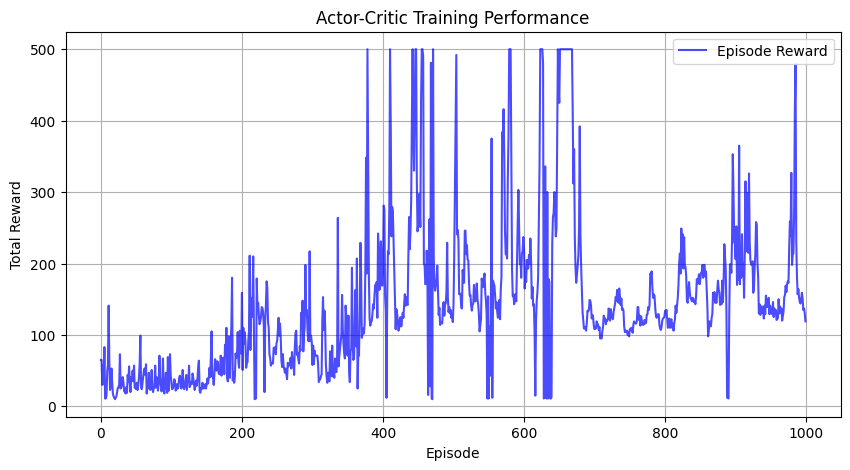

In [11]:
# Actor-Critic 방식의 성능을 시각화하고자 plot 하는 함수를 추가한 코드
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# --- Actor-Critic 네트워크 정의 ---
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_dim)
        self.fc_critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        policy_logits = self.fc_actor(x)  # 행동 점수(logits)
        value = self.fc_critic(x)  # 상태 가치
        return policy_logits, value

# --- 학습 함수 ---
# 하이퍼 파라미터를 함수 인자로 넣어줬다:
def train(env, model, optimizer, gamma=0.99, num_episodes=1000):
    reward_list = []  # 성능 기록을 위한 리스트

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state)
        done = False
        episode_reward = 0

        while not done:
            policy_logits, value = model(state)
            policy = F.softmax(policy_logits, dim=-1)
            dist = torch.distributions.Categorical(policy)
            action = dist.sample()

            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.FloatTensor(next_state)
            episode_reward += reward

            # TD 타깃과 Advantage 계산
            _, next_value = model(next_state)
            td_target = reward + gamma * next_value * (1 - int(done))
            advantage = td_target - value

            # 손실 계산
            actor_loss = -dist.log_prob(action) * advantage.detach()
            critic_loss = advantage.pow(2)
            loss = actor_loss + critic_loss

            # 모델 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        reward_list.append(episode_reward)  # 보상 기록
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    return reward_list  # 학습 후 보상 기록 반환

# --- 성능 그래프 출력 ---
def plot_rewards(reward_list):
    plt.figure(figsize=(10,5))
    plt.plot(reward_list, label='Episode Reward', color='blue', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Actor-Critic Training Performance')
    plt.legend()
    plt.grid()
    plt.show()

# --- 메인 실행 코드 ---
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_episodes = 1000  # 학습 에피소드 수 500, 1000, etc.
reward_list = train(env, model, optimizer, num_episodes=num_episodes)

env.close()

# 학습 성능 그래프 출력
plot_rewards(reward_list)

Episode 1: Reward = 14.0
Episode 2: Reward = 16.0
Episode 3: Reward = 28.0
Episode 4: Reward = 21.0
Episode 5: Reward = 28.0
Episode 6: Reward = 50.0
Episode 7: Reward = 38.0
Episode 8: Reward = 84.0
Episode 9: Reward = 48.0
Episode 10: Reward = 57.0
Episode 11: Reward = 38.0
Episode 12: Reward = 31.0
Episode 13: Reward = 30.0
Episode 14: Reward = 24.0
Episode 15: Reward = 16.0
Episode 16: Reward = 23.0
Episode 17: Reward = 21.0
Episode 18: Reward = 12.0
Episode 19: Reward = 18.0
Episode 20: Reward = 12.0
Episode 21: Reward = 15.0
Episode 22: Reward = 12.0
Episode 23: Reward = 14.0
Episode 24: Reward = 11.0
Episode 25: Reward = 9.0
Episode 26: Reward = 10.0
Episode 27: Reward = 9.0
Episode 28: Reward = 10.0
Episode 29: Reward = 9.0
Episode 30: Reward = 10.0
Episode 31: Reward = 10.0
Episode 32: Reward = 10.0
Episode 33: Reward = 8.0
Episode 34: Reward = 9.0
Episode 35: Reward = 10.0
Episode 36: Reward = 10.0
Episode 37: Reward = 9.0
Episode 38: Reward = 10.0
Episode 39: Reward = 9.0
Ep

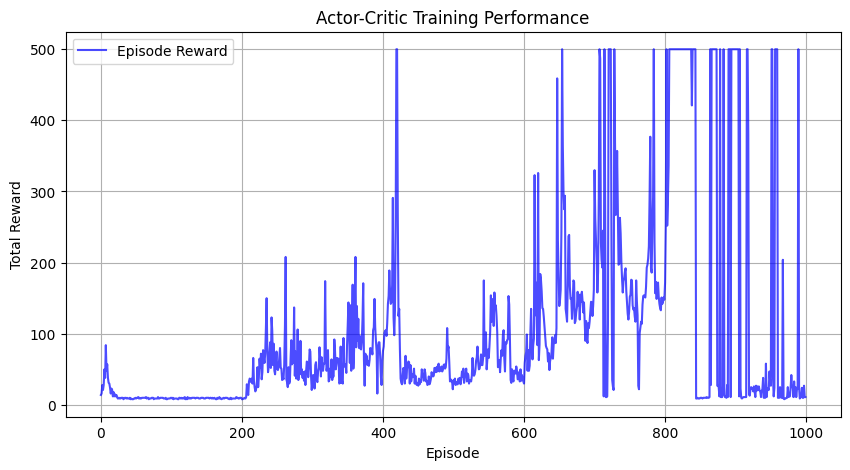

In [12]:
# 한 번 더

# Actor-Critic 방식의 성능을 시각화하고자 plot 하는 함수를 추가한 코드
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# --- Actor-Critic 네트워크 정의 ---
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_dim)
        self.fc_critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        policy_logits = self.fc_actor(x)  # 행동 점수(logits)
        value = self.fc_critic(x)  # 상태 가치
        return policy_logits, value

# --- 학습 함수 ---
def train(env, model, optimizer, gamma=0.99, num_episodes=1000):
    """
    # 하이퍼파라미터 설정
    learning_rate = 0.001
    gamma = 0.99
    max_episodes = 1000
    """
    reward_list = []  # 성능 기록을 위한 리스트

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state)
        done = False
        episode_reward = 0

        while not done:
            policy_logits, value = model(state)
            policy = F.softmax(policy_logits, dim=-1)
            dist = torch.distributions.Categorical(policy)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.FloatTensor(next_state)
            episode_reward += reward

            # TD 타깃과 Advantage 계산
            _, next_value = model(next_state)
            td_target = reward + gamma * next_value * (1 - int(done))
            advantage = td_target - value

            # 손실 계산
            actor_loss = -log_prob * advantage.detach()
            critic_loss = advantage.pow(2)
            loss = actor_loss + critic_loss

            # 모델 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        reward_list.append(episode_reward)  # 보상 기록
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    return reward_list  # 학습 후 보상 기록 반환

# --- 성능 그래프 출력 ---
def plot_rewards(reward_list):
    plt.figure(figsize=(10,5))
    plt.plot(reward_list, label='Episode Reward', color='blue', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Actor-Critic Training Performance')
    plt.legend()
    plt.grid()
    plt.show()

# --- 메인 실행 코드 ---
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_episodes = 1000  # 학습 에피소드 수 500, 1000, etc.
reward_list = train(env, model, optimizer, num_episodes=num_episodes)

env.close()

# 학습 성능 그래프 출력
plot_rewards(reward_list)

In [16]:
print("reward 최소값: {}, 최대값: {}".format(min(reward_list), max(reward_list)))

reward 최소값: 8.0, 최대값: 500.0
